# LLM router

Author: Georgios Giannkoulias

The goal of the project is to create an LLM router. I want to start simple, thus I create a simple model of distinguishing wether a task is "easy" vs "hard" and thus routing it to a small low cost model (like LLama3 7b in) vs big costly model (like ChatGPT).

In [13]:
# installations for google colab

# !pip3 install datasets
# !pip3 install evaluate
# !pip3 install accelerate -U
# !pip3 install diffusers transformers accelerate scipy safetensors --upgrade
# !pip3 install torchvision
# !pip3 install peft
# !python3 -m pip install openai



We use [this dataset](https://huggingface.co/datasets/lmsys/chatbot_arena_conversations), that has pairwise rankings of different llms.

In [14]:
from datasets import load_dataset
import random
import math
import itertools
import time
from tqdm import tqdm
from openai import OpenAI
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

from collections import Counter
import matplotlib.pyplot as plt


random.seed(42)



In [15]:
# load personal tokens and API keys
from dotenv import load_dotenv
from os import environ
load_dotenv()

HF_TOKEN = environ["HF_TOKEN"]
OPENAI_API_KEY = environ["OPENAI_API_KEY"]

## Creation of Dataset for router training

In [7]:
def view_samples_of_dataset(ds, amount = 3):
    print(f"* {ds.shuffle()[:amount]}")

def view_samples_of_datasetdict(dd, amount = 3):
  for name, ds in dd.items():
    print(f"Dataset {name}:")
    view_samples_of_dataset(ds)



In [8]:
dd = load_dataset("lmsys/mt_bench_human_judgments", token=HF_TOKEN)

In [9]:
dd

DatasetDict({
    gpt4_pair: Dataset({
        features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn'],
        num_rows: 2400
    })
    human: Dataset({
        features: ['question_id', 'model_a', 'model_b', 'winner', 'judge', 'conversation_a', 'conversation_b', 'turn'],
        num_rows: 3355
    })
})

In [84]:
view_samples_of_datasetdict(dd)

Dataset gpt4_pair:
* {'question_id': [112, 113, 82], 'model_a': ['llama-13b', 'llama-13b', 'gpt-3.5-turbo'], 'model_b': ['gpt-3.5-turbo', 'gpt-4', 'gpt-4'], 'winner': ['model_b', 'model_b', 'model_b'], 'judge': ['gpt4_pair', 'gpt4_pair', 'gpt4_pair'], 'conversation_a': [[{'content': "A tech startup invests $8000 in software development in the first year, and then invests half of that amount in software development in the second year.\nWhat's the total amount the startup invested in software development over the two years?", 'role': 'user'}, {'content': 'The startup invested $16,000 in software development over the two years.', 'role': 'assistant'}, {'content': "If the startup maintains the same strategy for the third year, investing half of the previous year's amount into software development, how much will they invest in the third year?", 'role': 'user'}, {'content': 'The startup will invest $8,000 in software development in the third year.', 'role': 'assistant'}], [{'content': "In a 

In [85]:
print(f"Number of questions: {len(set(dd['human']['question_id']))}")

Number of questions: 80


In [86]:
# display all models existing in the dataset
human_ds = dd['human']
print(f"Example conversation: {human_ds['conversation_a'][0]}")

model_names = list(sorted(set([*human_ds["model_a"], *human_ds["model_b"]])))
print(f"{model_names=}")


Example conversation: [{'content': 'Compose an engaging travel blog post about a recent trip to Hawaii, highlighting cultural experiences and must-see attractions.', 'role': 'user'}, {'content': 'I recently had the pleasure of visiting Hawaii and it quickly became one of my favorite places. From the stunning beaches to the lush mountains, this place has it all. The people are incredibly friendly and the culture is alive and well. One of the highlights of my trip was visiting the Polynesian Cultural Center. Here, I was able to learn about the culture of the native Hawaiian people and try my hand at traditional crafts and activities. I also had a chance to explore some of the natural wonders of the island, including the breathtaking Hanauma Bay and the majestic Waimea Canyon. Whether you’re looking for a relaxing beach vacation or an adventure filled with culture and nature, Hawaii is the perfect destination.', 'role': 'assistant'}, {'content': 'Rewrite your previous response. Start ever

In [87]:
# sort the human dataset
def sort_model_names_func(row):
  if row['model_a'] > row['model_b']:
     row['model_a'], row['model_b'] = row['model_b'], row['model_a']
     row['conversation_a'], row['conversation_b'] = row['conversation_b'], row['conversation_a']
     if row['winner'] == 'model_a':
        row['winner'] = 'model_b'
     elif row['winner'] == 'model_b':
        row['winner'] = 'model_a'
  return row

human_ds = human_ds.map(sort_model_names_func)

In [88]:
view_samples_of_dataset(human_ds)
human_df = human_ds.to_pandas()
human_df.head()

* {'question_id': [99, 137, 131], 'model_a': ['gpt-3.5-turbo', 'alpaca-13b', 'gpt-3.5-turbo'], 'model_b': ['gpt-4', 'gpt-3.5-turbo', 'llama-13b'], 'winner': ['model_a', 'model_b', 'model_a'], 'judge': ['expert_24', 'author_0', 'expert_20'], 'conversation_a': [[{'content': 'Suppose you are a mathematician and poet. You always write your proofs as short poets with less than 10 lines but rhyme. Prove the square root of 2 is irrational number.', 'role': 'user'}, {'content': "The square root of two, I'll prove,\nIs irrational, it cannot move\nFrom a fraction, p over q,\nWhere p and q have no common view.\n\nSuppose it can, and write it so,\nWith p and q both in a row,\nReduced to lowest terms, you see,\nThen two is p^2 over q^2, can't be.\n\nFor if it were, then p^2 is even,\nAnd so is p, or so we're given,\nBut then q^2 is even too,\nAnd p and q have a common view.\n\nSo now we see, it can't be done,\nThe square root of two, it is one,\nIrrational, not a fraction neat,\nA fact that's true,

,question_id,model_a,model_b,winner,judge,conversation_a,conversation_b,turn
0,81,alpaca-13b,gpt-3.5-turbo,model_b,author_2,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
1,81,alpaca-13b,gpt-3.5-turbo,model_b,author_2,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2
2,81,alpaca-13b,gpt-3.5-turbo,model_b,expert_17,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1
3,81,alpaca-13b,gpt-3.5-turbo,model_b,expert_17,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,2
4,81,alpaca-13b,vicuna-13b-v1.2,model_b,expert_0,[{'content': 'Compose an engaging travel blog ...,[{'content': 'Compose an engaging travel blog ...,1


In [89]:
winner_types = set(human_df['winner']) 
print(f"{winner_types=}")

winner_types={'tie', 'model_a', 'model_b'}


In [90]:
human_df['winner_name'] = human_df.apply(lambda row: 'tie' if row['winner'] == 'tie' else (row['model_a'] if row['winner'] == 'model_a' else row['model_b']), axis=1)

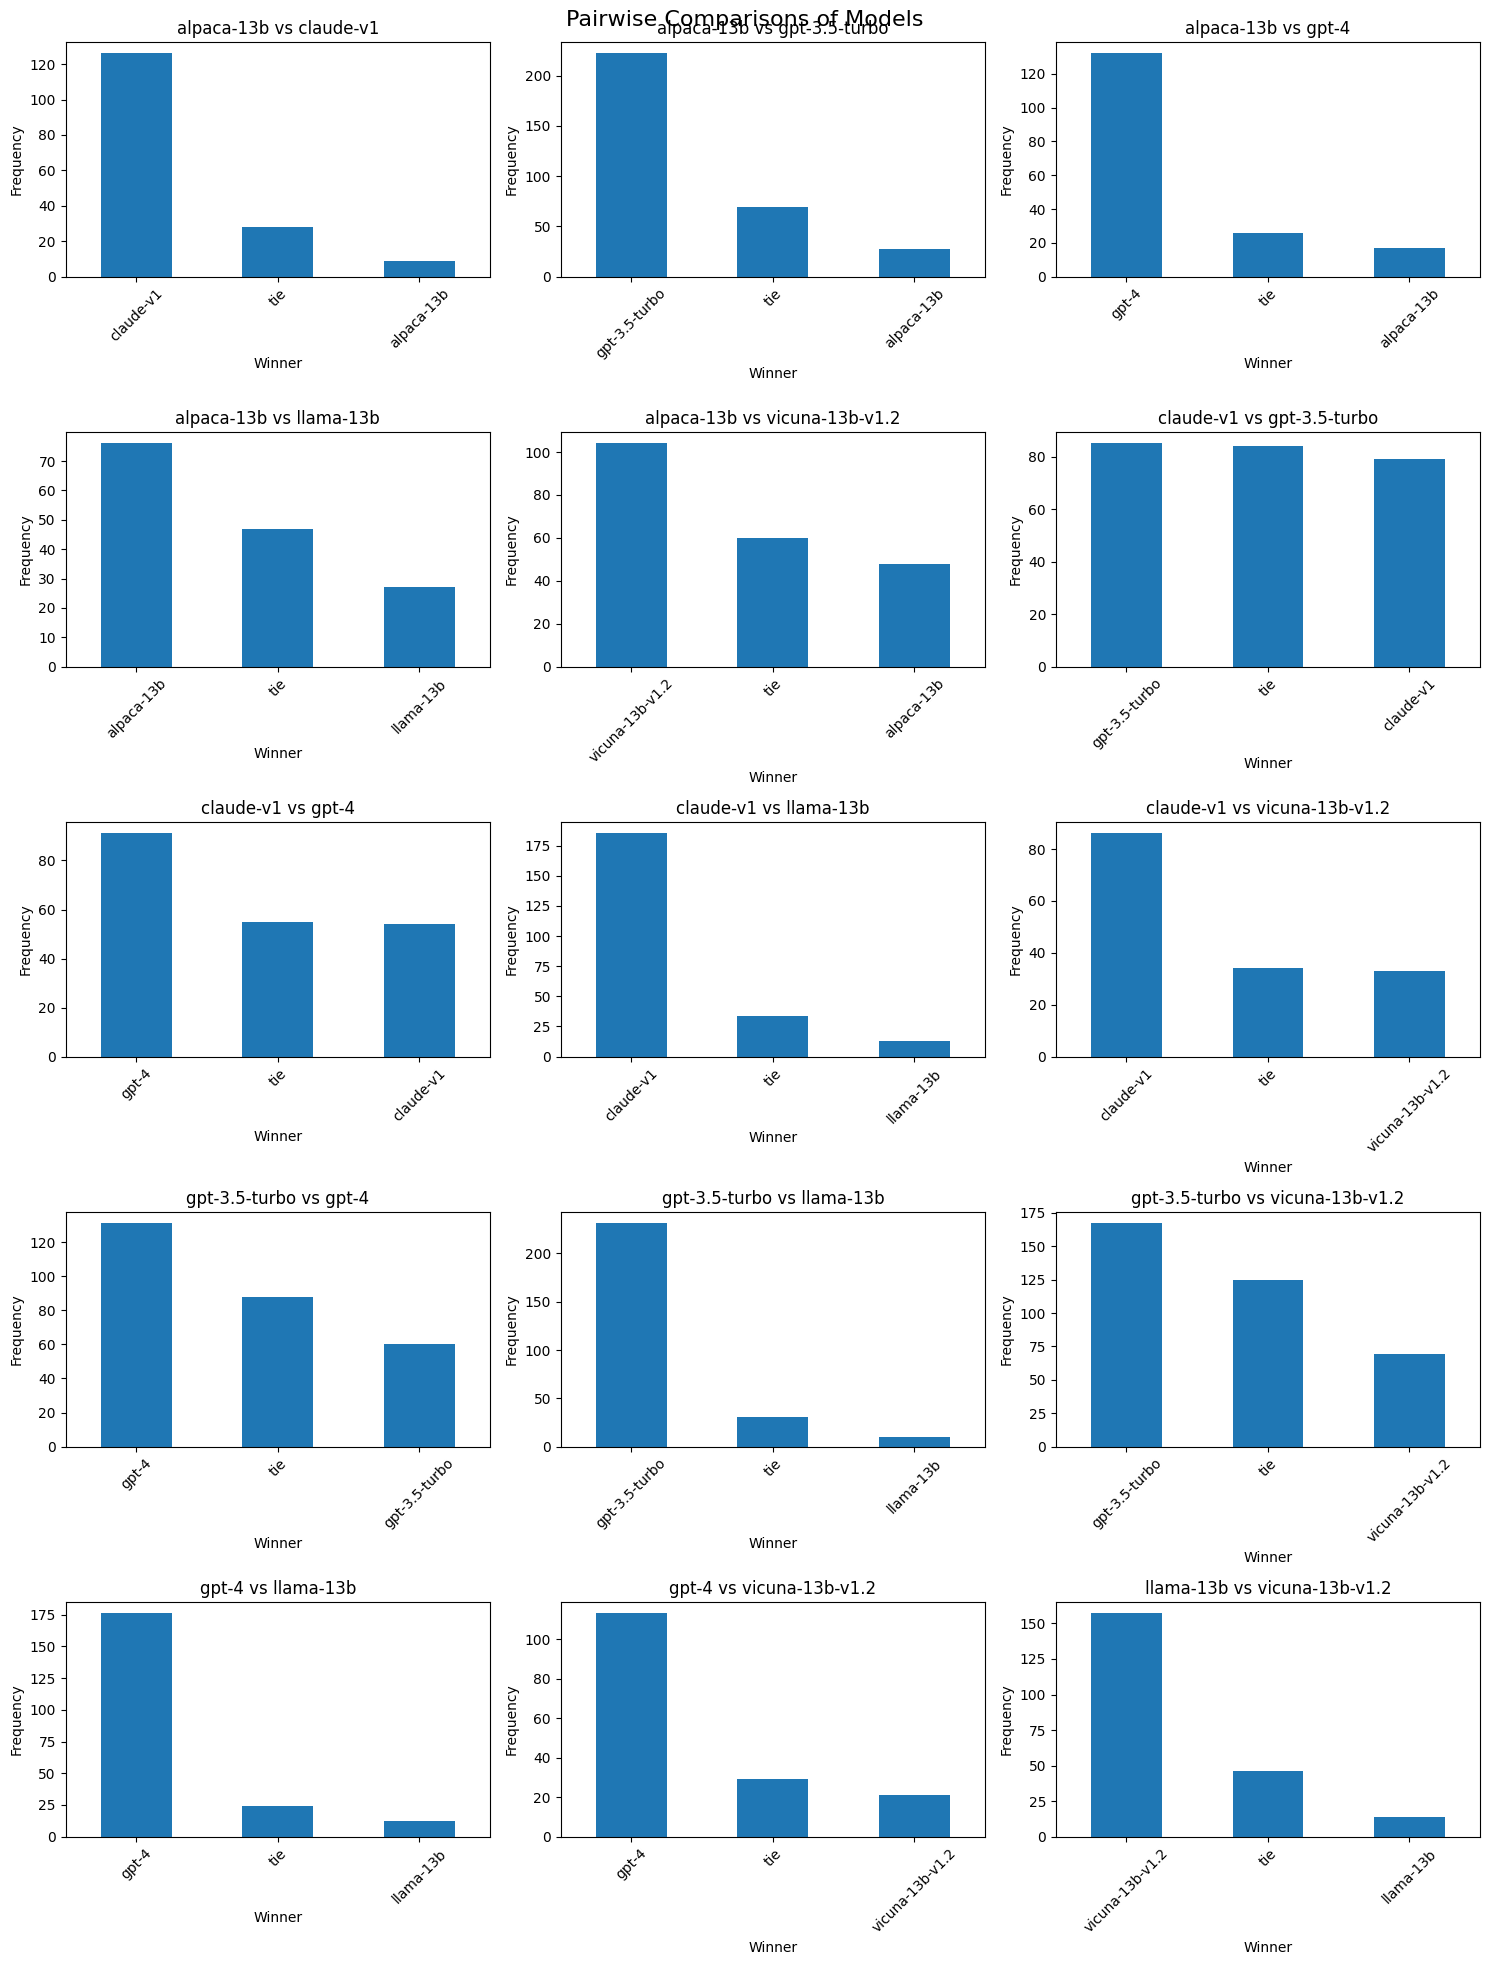

In [91]:
def create_pairwise_plots(df):
    model_names = list(sorted(set(df['model_a'].tolist() + df['model_b'].tolist())))
    model_pairs = list(itertools.combinations(model_names, 2))

    # Calculate the number of rows and columns for the subplots
    n_plots = len(model_pairs)
    n_cols = min(3, n_plots)  # Maximum 3 columns
    n_rows = math.ceil(n_plots / n_cols)

    # Create the main figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    fig.suptitle('Pairwise Comparisons of Models', fontsize=16)

    # Flatten the axes array for easier indexing
    axes = axes.flatten() if n_plots > 1 else [axes]

    for idx, (model_a_name, model_b_name) in enumerate(model_pairs):
        filtered_df = df[(df['model_a'] == model_a_name) & (df['model_b'] == model_b_name)]
        value_counts = filtered_df['winner_name'].value_counts()

        ax = axes[idx]
        value_counts.plot(kind='bar', ax=ax)

        ax.set_title(f'{model_a_name} vs {model_b_name}')
        ax.set_xlabel('Winner')
        ax.set_ylabel('Frequency')
        ax.tick_params(axis='x', rotation=45)

    # Remove any unused subplots
    for idx in range(n_plots, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

        # print(model_a_name, model_b_name)

create_pairwise_plots(human_df)

The diagram above helps us verify some assumptions. As we expected `gpt-4` is superior. Following that, `claude-v1` and `gpt-3.5` are really good. Then with much difference `vicuna-13b` followed by `alpaca-13b` and `llama-13b`.
This is to be expected, since these models have much less parameters. To keep things simple, we are going to split the models into two categories.

In [92]:
superior_models = [
    'gpt-3.5-turbo',
    'gpt-4',
]

inferior_models = [
    'alpaca-13b',
    'llama-13b'
]


unused_models = [
    'vicuna-13b-v1.2',
    'claude-v1',
]

model_pairs = [tuple(sorted(list(x))) for x in itertools.product(superior_models,inferior_models)]
model_pairs

[('alpaca-13b', 'gpt-3.5-turbo'),
 ('gpt-3.5-turbo', 'llama-13b'),
 ('alpaca-13b', 'gpt-4'),
 ('gpt-4', 'llama-13b')]

This time, we will plot the amount of times the small models are actually considered superior than the smaller models. What we want to achieve is a ranking of the datasets questions.

In [93]:
# res = human_df.filter(lambda row: (row['model_a'], row['model_b']) in model_pairs)

questions_df = human_df[human_df.apply(lambda row: (row['model_a'], row['model_b']) in model_pairs, axis=1)]
grouped_df = questions_df.groupby('question_id')['winner_name'].value_counts().unstack(fill_value=0)

grouped_df['superior_count'] = grouped_df.apply(lambda row: row['gpt-4'] + row['gpt-3.5-turbo'], axis=1)
grouped_df['inferior_count'] = grouped_df.apply(lambda row: row['alpaca-13b'] + row['llama-13b'] + row['tie'], axis=1)
grouped_df['inferior_ratio'] = grouped_df['inferior_count'] / (grouped_df['inferior_count'] + grouped_df['superior_count'])
grouped_df = grouped_df.sort_values('inferior_ratio', ascending=False).reset_index()

question_ranked = list(zip(grouped_df['question_id'], grouped_df['inferior_ratio']))
question_ranked

# inferior ratio close to 1 means that people prefer inferior models for answering this questions

[(105, 0.9375),
 (107, 0.875),
 (109, 0.8125),
 (100, 0.5625),
 (104, 0.5),
 (102, 0.5),
 (136, 0.5),
 (108, 0.5),
 (132, 0.5),
 (88, 0.5),
 (120, 0.5),
 (111, 0.42857142857142855),
 (106, 0.4),
 (116, 0.4),
 (83, 0.4),
 (157, 0.375),
 (85, 0.375),
 (118, 0.375),
 (110, 0.3333333333333333),
 (89, 0.3333333333333333),
 (134, 0.3333333333333333),
 (125, 0.3333333333333333),
 (82, 0.3333333333333333),
 (114, 0.3125),
 (140, 0.3125),
 (84, 0.3),
 (124, 0.25),
 (97, 0.25),
 (144, 0.25),
 (145, 0.25),
 (150, 0.25),
 (156, 0.25),
 (160, 0.25),
 (92, 0.22727272727272727),
 (121, 0.2),
 (133, 0.1875),
 (113, 0.1875),
 (152, 0.1875),
 (91, 0.16666666666666666),
 (155, 0.16666666666666666),
 (126, 0.16666666666666666),
 (130, 0.16666666666666666),
 (123, 0.14285714285714285),
 (153, 0.14285714285714285),
 (96, 0.14285714285714285),
 (148, 0.125),
 (127, 0.125),
 (128, 0.125),
 (139, 0.1111111111111111),
 (142, 0.1),
 (138, 0.1),
 (129, 0.1),
 (131, 0.1),
 (101, 0.08333333333333333),
 (95, 0.08333

Using the aforementioned ranking, we can define a threshold ratio that we consider acceptable for routing to the inferior models. In this case, I am using an inferior_ratio above 0.4

In [94]:
# hyperparameters
route_inferior_threshold = 0.4
route_superior_threshold = 0.2


In [95]:
# labels
LABEL_INF = "ROUTE_TO_INFERIOR"
LABEL_SUP = "ROUTE_TO_SUPERIOR"
LABEL_SKIP = "ROUTE_NOT"
question_to_inferior = set(qid for qid, rt in question_ranked if rt >= route_inferior_threshold)
question_to_superior = set(qid for qid, rt in question_ranked if rt < route_superior_threshold)
print(f"qs to inferior = {len(question_to_inferior)} vs qs to superior = {len(question_to_superior)}")

qs to inferior = 15 vs qs to superior = 45


In [96]:
route_func = lambda r: LABEL_INF if r['question_id'] in question_to_inferior else (LABEL_SUP if r['question_id'] in question_to_superior else LABEL_SKIP)


In [97]:

unique_questions_df = questions_df.drop_duplicates(subset='question_id', keep='first').copy()
unique_questions_df['question'] = unique_questions_df['conversation_a'].map(lambda x: x[0]['content'])
unique_questions_df = unique_questions_df[['question_id', 'question']].reset_index(drop=True)
unique_questions_df['label'] = unique_questions_df.apply(route_func, axis=1)
unique_questions_df.head(3)

,question_id,question,label
0,81,Compose an engaging travel blog post about a r...,ROUTE_TO_SUPERIOR
1,82,Draft a professional email seeking your superv...,ROUTE_NOT
2,83,Imagine you are writing a blog post comparing ...,ROUTE_TO_INFERIOR


In [98]:
## saving for future use
filename = "original_questions_labelled.jsonl"
unique_questions_df.to_json(filename, orient="records", lines=True, mode="a")

## Creating a prompt

In [99]:
## dropping NOT_ROUTE questions
unique_questions_df = unique_questions_df[unique_questions_df['label'] != LABEL_SKIP]
unique_questions_df = unique_questions_df.sample(frac=1, random_state=17).reset_index(drop=True)

In [100]:
# we are going to use the unique questions dataframe to create a prompt for ChatGPT
prompt_task = f"""## TASK

You are a prompt classification expert.
Your task is to evaluate how easy/simple or diffuclt/complex a prompt to an LLM is.
You have to classify easy/simple prompts with label '{LABEL_INF}'.
You have to classify diffuclt/complex prompts with label '{LABEL_SUP}'.
Do not add more or less words, just respond with one of the two aforementioned labels.
Here are some examples in XML format to help you.

"""


In [101]:
# question_label_func = lambda q,l: f"\n* Question: {q}\n* Label: {l}\n"
question_label_func = lambda q,l: f"<pair>\n<question>{q}</question>\n<label>{l}</label>\n</pair>"

def make_examples_prompt(examples):
    # examples: iterable of tuples of type (question, label)
    examples_list = [f'{question_label_func(q, l)}\n\n' for q, l in examples]
    examples_prompt = f"## EXAMPLES\n{''.join(examples_list)}"
    return examples_prompt

In [102]:
def create_prompt(examples, question):
    placeholder = "____"
    examples_prompt = make_examples_prompt(examples)
    prompt = f"{prompt_task}{examples_prompt}## YOUR TURN\n{question_label_func(question, placeholder)}\n\nReplace {placeholder} with your answer"
    return prompt

In [103]:
def get_examples_from_df(df):
    return list(zip(df['question'],df['label']))

In [104]:
all_examples = get_examples_from_df(unique_questions_df)
question = "What is the color of the sky?"
print(create_prompt(all_examples, question))

## TASK

You are a prompt classification expert.
Your task is to evaluate how easy/simple or diffuclt/complex a prompt to an LLM is.
You have to classify easy/simple prompts with label 'ROUTE_TO_INFERIOR'.
You have to classify diffuclt/complex prompts with label 'ROUTE_TO_SUPERIOR'.
Do not add more or less words, just respond with one of the two aforementioned labels.
Here are some examples in XML format to help you.

## EXAMPLES
<pair>
<question>Thomas is very healthy, but he has to go to the hospital every day. What could be the reasons?</question>
<label>ROUTE_TO_SUPERIOR</label>
</pair>

<pair>
<question>Which methods did Socrates employ to challenge the prevailing thoughts of his time?</question>
<label>ROUTE_TO_SUPERIOR</label>
</pair>

<pair>
<question>Extract the following information from the presented texts: The name of the book, the author, the main character, the year of publication. Output in the format of "main character, book, author, year of publication", one book per l

## Evaluate how good chatGPT is in our dataset


In order to make sure that we can trust ChatGPT with labeling our data, we have to first evaluate what is it's performance to our current data.

In [16]:
client = OpenAI(api_key=OPENAI_API_KEY)

In [106]:
# testing the API key
def get_gpt_completion(user_content):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=[
        {"role": "user", "content": user_content}
      ],
      temperature=0.0
    )
    return completion

In [107]:
# the eval prompt only skips the question of the current row and makes a prompt for chat GPT to guess the relevant label
def create_eval_prompt(row):
    question = row['question']
    copy_examples = [x for x in all_examples if x != (row['question'], row['label'])]
    prompt = create_prompt(copy_examples, question)
    return prompt


In [118]:
unique_questions_df['gpt_eval_prompt'] = unique_questions_df.apply(create_eval_prompt, axis=1)
unique_questions_df['gpt_eval_prompt'].head(3)

0    ## TASK\n\nYou are a prompt classification exp...
1    ## TASK\n\nYou are a prompt classification exp...
2    ## TASK\n\nYou are a prompt classification exp...
Name: gpt_eval_prompt, dtype: object

In [109]:
unique_questions_df.tail()

,question_id,question,label,gpt_eval_prompt
55,109,"One morning after sunrise, Suresh was standing...",ROUTE_TO_INFERIOR,## TASK\n\nYou are a prompt classification exp...
56,91,Pretend yourself to be Elon Musk in all the fo...,ROUTE_TO_SUPERIOR,## TASK\n\nYou are a prompt classification exp...
57,102,You can see a beautiful red house to your left...,ROUTE_TO_INFERIOR,## TASK\n\nYou are a prompt classification exp...
58,146,Please explain the differences between exother...,ROUTE_TO_SUPERIOR,## TASK\n\nYou are a prompt classification exp...
59,142,Consider a satellite that is in a circular orb...,ROUTE_TO_SUPERIOR,## TASK\n\nYou are a prompt classification exp...


In [110]:
def process_df_with_tqdm(df, row_func, sleep_time=0.02):
    results = []
    for _, row in tqdm(df.iterrows(), total=df.shape[0], desc="Processing"):
        result = row_func(row)
        results.append(result)
        time.sleep(sleep_time)
    return results

# results = process_df_with_tqdm(unique_questions_df, row_func=lambda row: f"{row['label']}_and_other")

In [111]:
## RUNNING THE DATASET
## don't run all the time, this step charges you actual money

unique_questions_df['gpt_eval_completion'] = process_df_with_tqdm(
    unique_questions_df,
    row_func=lambda row: get_gpt_completion(row['gpt_eval_prompt'])
)


Processing: 100%|██████████| 60/60 [00:43<00:00,  1.37it/s]


In [112]:
# extracting the label given by ChatGPT
unique_questions_df['gpt_label'] = unique_questions_df['gpt_eval_completion'].map(lambda x: x.choices[0].message.content.strip())

In [113]:
# save format
unique_questions_df[['question_id', 'question', 'label', 'gpt_label']].to_json("original_questions-gpt_evaluation.jsonl", orient="records", lines=True)

In [114]:
print(Counter([x==y for x,y in zip(unique_questions_df['label'], unique_questions_df['gpt_label'])]))

Counter({True: 46, False: 14})


Let's perform a more thorough analysis on the predictions and labels.

In [115]:
targets = [int(x == "ROUTE_TO_SUPERIOR") for x in unique_questions_df['label']]
predictions = [int(x == "ROUTE_TO_SUPERIOR") for x in unique_questions_df['gpt_label']]

print(f"Counter targets: {Counter(targets)}")
print(f"Counter predictions: {Counter(predictions)}")

Counter targets: Counter({1: 45, 0: 15})
Counter predictions: Counter({1: 45, 0: 15})


We observe that dataset is imbalanced, since humans generally prefer predictions from the superior models. GPT however tends to have similar inferior/superior ratio in it's predictions, which is a desirable.

In [116]:
# Calculate metrics
accuracy = accuracy_score(targets, predictions)
precision = precision_score(targets, predictions)
recall = recall_score(targets, predictions)

# Get confusion matrix
tn, fp, fn, tp = confusion_matrix(targets, predictions).ravel()

# Print results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"True Positives: {tp}")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")


Accuracy: 0.77
Precision: 0.84
Recall: 0.84
True Positives: 38
True Negatives: 8
False Positives: 7
False Negatives: 7


From the metrics above, we can conclude that ChatGPT has actually a labeling capability better than 50% (around 75%), so we can use it to label more data and hence produce a fairly good dataset. When recall is higher than precision, that means that GPT tends to classify more towards the `ROUTE_TO_SUPERIOR` label. In this case recall is more desirable, because routing to the superior model will almost always result in high quality answers, thus we will not sacrifice the quality for our users' prompt because of incorrect routing.

END OF PROJECT